In [1]:
import os
import torch
from franka import Franka
from omegaconf import OmegaConf
from models import get_model
from loader import get_dataloader
from utils import Kinematics_numpy
from tqdm import tqdm


import sys
sys.path.append('../../')
from utils.visualization import SE3_Trajectory_Visualization
from metrics import SE3_trajectory_distance, Encoder_invariance

device = 'cpu'

%matplotlib widget

/home/bhlee/anaconda3/envs/equilfd/lib/python3.10/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [2]:
import loader 
from models import load_pretrained
from loader import get_latent_dataloader
from loader.latent_dataset import LatentDataset
from utils.utils import get_pretrained_model_cfg, get_n_params
from models.groups import PlanarMobileRobot
from models.Latent_sampler import get_optimized_GMM, get_optimized_GMM_latent
from evaluation.evaluation_tools import (
    get_collision_bc_model, 
    cal_success_rate, 
    cal_entropy,
    cal_log_p_ambient,
)
import torch
import numpy as np
import utils.LieGroup_torch as lie

In [5]:
# Data loader
skip_size=1

loader_dict = {
'dataset': 'Pouring',
'root': '../datasets/',
'batch_size': 75,
'n_workers': 4,
'split': 'training',
'skip_size': skip_size,
'shuffle': False,
'augmentation': True,
}
# Data loader
loader_dict_val = {
'dataset': 'Pouring',
'root': '../datasets/',
'batch_size': 75,
'n_workers': 4,
'split': 'validation',
'skip_size': skip_size,
'shuffle': False,
'augmentation': True,
}
loader_dict_test = {
'dataset': 'Pouring',
'root': '../datasets/',
'batch_size': 75,
'n_workers': 4,
'split': 'test',
'skip_size': skip_size,
'shuffle': False,
'augmentation': True,
}
dataloader = loader.get_dataloader(loader_dict)
valloader = loader.get_dataloader(loader_dict_val)
testloader = loader.get_dataloader(loader_dict_test)

training dataset for Pouring is ready. [125, 5760]
validation dataset for Pouring is ready. [2500, 5760]
test dataset for Pouring is ready. [25000, 5760]


In [12]:
xml_root = ''
franka_xml_path = os.path.join(xml_root, 'franka_panda_robot_only_cat.xml')
franka_model = Franka(franka_xml_path)

KeyError: 'fullinertia'

In [ ]:
# cfg_path = '../results/Pouring/TCVAE/TCN/a0.5_z2_[512,512]_[36,72,144]_lr0.0001_wd0.0/tc_tcn_aux.yml'
# ckfg_path = '../results/Pouring/TCVAE/TCN/a0.5_z2_[512,512]_[36,72,144]_lr0.0001_wd0.0/model_best.pkl'

# cfg = OmegaConf.load(cfg_path)
# model = get_model(cfg).to(device)
# model.load_state_dict(torch.load(ckfg_path, map_location=device)['model_state'])

# d_dataloaders = {}
# data_name = cfg["data"]["training"]["dataset"]
# for key, dataloader_cfg in cfg["data"].items():
#     dataloader_cfg['path'] = '../datasets'
#     d_dataloaders[key] = get_dataloader(dataloader_cfg)

# dl_train = d_dataloaders['training']
# dl_test = d_dataloaders['test']


# x_train = []
# w_train = []
# for x, w in dl_train:
#     x_train.append(x.to(device))
#     w_train.append(w.to(device))

# x_train = torch.cat(x_train, dim=0)
# w_train = torch.cat(w_train, dim=0)

# x_test = []
# w_test = []
# for x, w in dl_test:
#     x_test.append(x.to(device))
#     w_test.append(w.to(device))
    
# x_test = torch.cat(x_test, dim=0)
# w_test = torch.cat(w_test, dim=0)

# batch_size = x_train.size()[0]
# time_step = x_train.size()[1]

# x_train = x_train.reshape(batch_size, time_step, 3, 4)
# temp = torch.tensor([0, 0, 0, 1], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(75, 270, 1).unsqueeze(2)
# x_train = torch.cat((x_train, temp), dim=2)
# print(x_train.size())

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/Pouring/test'

In [9]:
x_train = lie.SE3_12dim_to_mat(dataloader.dataset.traj_data)

In [12]:
T_traj_via = x_train[0].detach().numpy()
# q_init = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# q_init = [-1.91413255, -1.40266464,  0.6533821 , -1.18612957,  1.71732091, 2.22385606,  0.85433674] + np.random.randn(7) * 0.5 #random
# q_init = [-2.0057030425573648, -1.552928994346083, 0.7110544694766664, -1.4998763583380144, 0.5, 0.5, 0.5] # manually obtained 1
# q_init = [-2.0057030425573648, -1.552928994346083, 0.7110544694766664, -1.4998763583380144, 2.04421532477604, 2.240111422960053, 0.5090758493349987] # manually obtained 1
# q_init = [-1.2743258014917371, -0.9797194011755155, 1.1528589829073526, -1.7797570616404212, 1.7625199890487084, 2.852610510773129, -0.011556249000265523] # manually obtained 2
# q_init = [-0.48230601, -0.39131458, -0.05519465, -0.52731423, 0.41012392, 0.23156516, 0.13954788]
# q_init = [-1.91413255, -1.40266464,  0.6533821 , -1.18612957,  1.71732091, 2.22385606,  0.85433674]
q_traj_via = []
q_traj_via.append(q_init)

for i in tqdm(range(len(T_traj_via))):
    q_traj_via.append(Kinematics_numpy.inverse_kinematics(
        franka_model.initialEEFrame,
        T_traj_via[i].copy(),
        q_traj_via[-1].copy(),
        franka_model.S_screw,
        show=False,
        max_iter=2000,
        tolerance=0.0001,
        step_size=0.01,
        step_size2=0.0001,
        step_size3=0,
        joint_limit=franka_model.joint_limit,
        singular_avoidance=False # True
    ))

  0%|          | 0/480 [00:00<?, ?it/s]


LinAlgError: Singular matrix

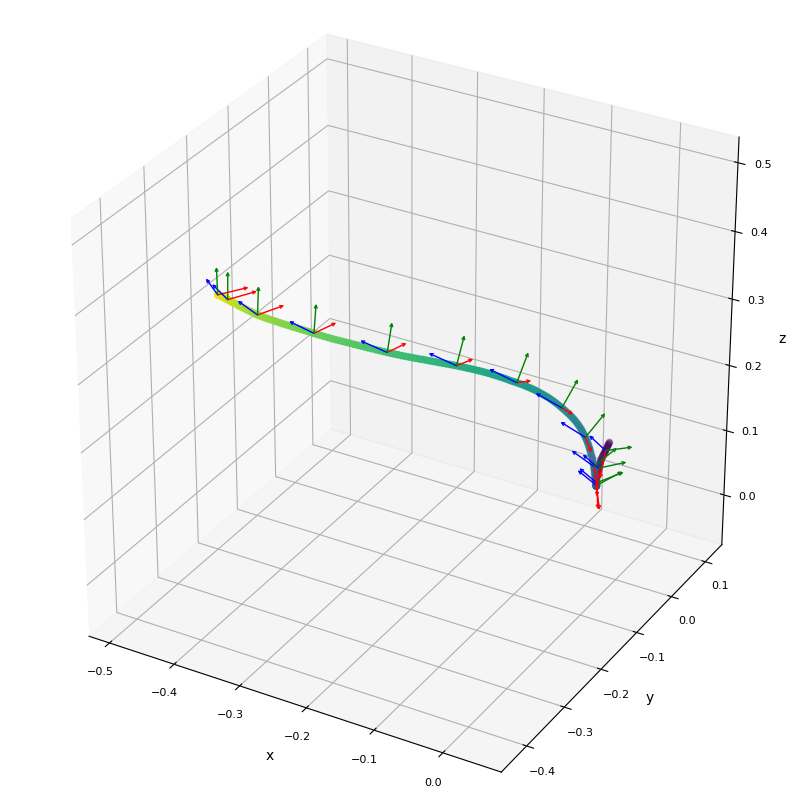

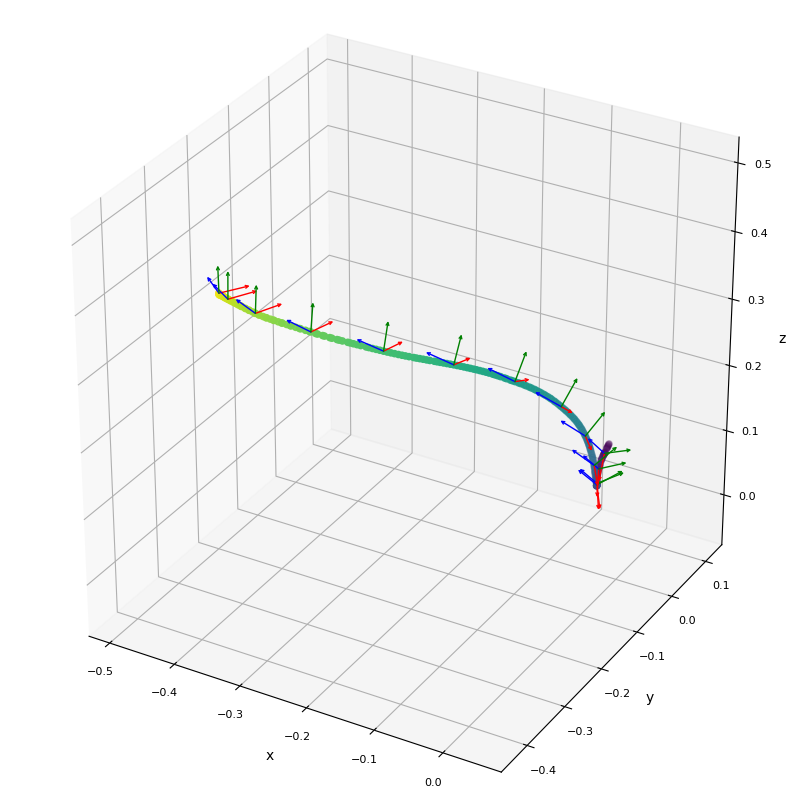

In [5]:
recon_T_traj_via = []
for i in range(len(q_traj_via)-1):
    _, EEFrame = Kinematics_numpy.forward_kinematics(jointPos = q_traj_via[i+1], S_screw=franka_model.S_screw, initialEEFrame=franka_model.initialEEFrame)
    recon_T_traj_via.append(EEFrame)
    
recon_T_traj_via = torch.tensor(recon_T_traj_via, dtype=torch.float32)

fig1 = SE3_Trajectory_Visualization(traj=x_train[0, :, :3, :])
fig2 = SE3_Trajectory_Visualization(traj=recon_T_traj_via[:, :3, :])

In [27]:
import torch
import sys
sys.path.append('..')
import utils.LieGroup_torch as lie
a = torch.zeros(30, 3, 3)
a[..., range(3), range(3)] = 1
b = (torch.ones(30, 3)*0.3).reshape(-1, 3, 1)

In [38]:
c = torch.cat([a, b], dim=2).reshape(3, -1)
cc = lie.SE3_12dim_to_mat(c)
print(c.shape,'\n', cc)

torch.Size([3, 120]) 
 tensor([[[[1.0000, 0.0000, 0.0000, 0.3000],
          [0.0000, 1.0000, 0.0000, 0.3000],
          [0.0000, 0.0000, 1.0000, 0.3000],
          [0.0000, 0.0000, 0.0000, 1.0000]],

         [[1.0000, 0.0000, 0.0000, 0.3000],
          [0.0000, 1.0000, 0.0000, 0.3000],
          [0.0000, 0.0000, 1.0000, 0.3000],
          [0.0000, 0.0000, 0.0000, 1.0000]],

         [[1.0000, 0.0000, 0.0000, 0.3000],
          [0.0000, 1.0000, 0.0000, 0.3000],
          [0.0000, 0.0000, 1.0000, 0.3000],
          [0.0000, 0.0000, 0.0000, 1.0000]],

         [[1.0000, 0.0000, 0.0000, 0.3000],
          [0.0000, 1.0000, 0.0000, 0.3000],
          [0.0000, 0.0000, 1.0000, 0.3000],
          [0.0000, 0.0000, 0.0000, 1.0000]],

         [[1.0000, 0.0000, 0.0000, 0.3000],
          [0.0000, 1.0000, 0.0000, 0.3000],
          [0.0000, 0.0000, 1.0000, 0.3000],
          [0.0000, 0.0000, 0.0000, 1.0000]],

         [[1.0000, 0.0000, 0.0000, 0.3000],
          [0.0000, 1.0000, 0.0000, 0.3000],